## Testing Spatial K-Fold Cross Validation

In [8]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV, spatial_train_test_split, SKCV_simple
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, GroupKFold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis Parameters

In [9]:
training_data = "gm_mads_two_seasons_training_data_20201204.txt"
coordinate_data = "training_data_coordinates_20201204.txt"

cv_splits = 5

max_distance = 250000

test_size = 0.20

cluster_method='Hierarchical'

### Load data

In [10]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

## Generate spatial clusters to visualize

n clusters = 89


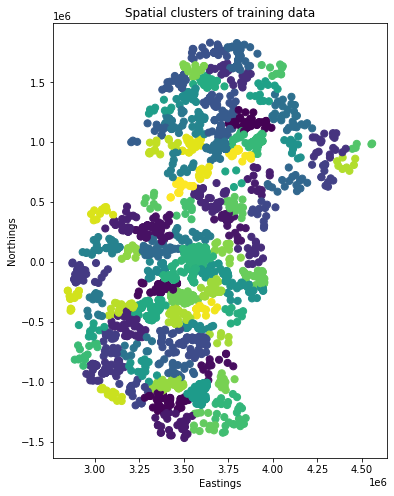

In [11]:
spatial_groups = spatial_clusters(coordinates, method='Hierarchical',
                                  max_distance=max_distance, verbose=True)

plt.figure(figsize=(6,8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=spatial_groups,
            s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('Northings')
plt.xlabel('Eastings');

In [12]:
len(np.unique(spatial_groups))

89

## Test the different SKCV methods and random shufflesplit

In [14]:
#generate n_splits of train-test_splits
kfold = SKCV_simple(coordinates=coordinates,
                    max_distance=max_distance,
                    n_splits=cv_splits,
                    cluster_method=cluster_method,
                    kfold_method='SpatialKFold',
                    test_size=test_size,
                    random_state=1
                            )
# kfold=kfold.split(coordinates)

shuffle = SKCV_simple(coordinates=coordinates,
                    max_distance=max_distance,
                    n_splits=cv_splits,
                    cluster_method=cluster_method,
                    kfold_method='SpatialShuffleSplit',
                    random_state=1,
                    test_size=test_size)

# shuffle = shuffle.split(coordinates)

rs = ShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=1)
rs = rs.split(coordinates)

gss = GroupShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=1)
gss = gss.split(coordinates, groups=spatial_groups)

gkf = GroupKFold(n_splits=cv_splits)
gkf = gkf.split(coordinates, groups=spatial_groups)

In [ ]:
# #generate n_splits of train-test_splits
# kfold = SKCV(coordinates=coordinates,
#     max_distance=max_distance,
#     n_splits=cv_splits,
#     cluster_method=cluster_method,
#     kfold_method='SpatialKFold',
#     test_size=test_size,
#     balance=True
#             )

# kfold=kfold.split(coordinates)

# shuffle = SKCV(coordinates=coordinates,
#     max_distance=max_distance,
#     n_splits=cv_splits,
#     cluster_method=cluster_method,
#     kfold_method='SpatialShuffleSplit',
#     test_size=test_size,
#     balance=10
#               )
# shuffle = shuffle.split(coordinates)

# rs = ShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=0)
# rs = rs.split(coordinates)

# gss = GroupShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=0)
# gss = gss.split(coordinates, groups=spatial_groups)

# gkf = GroupKFold(n_splits=cv_splits)
# gkf = gkf.split(coordinates, groups=spatial_groups)

### Plot train-test coordinate data

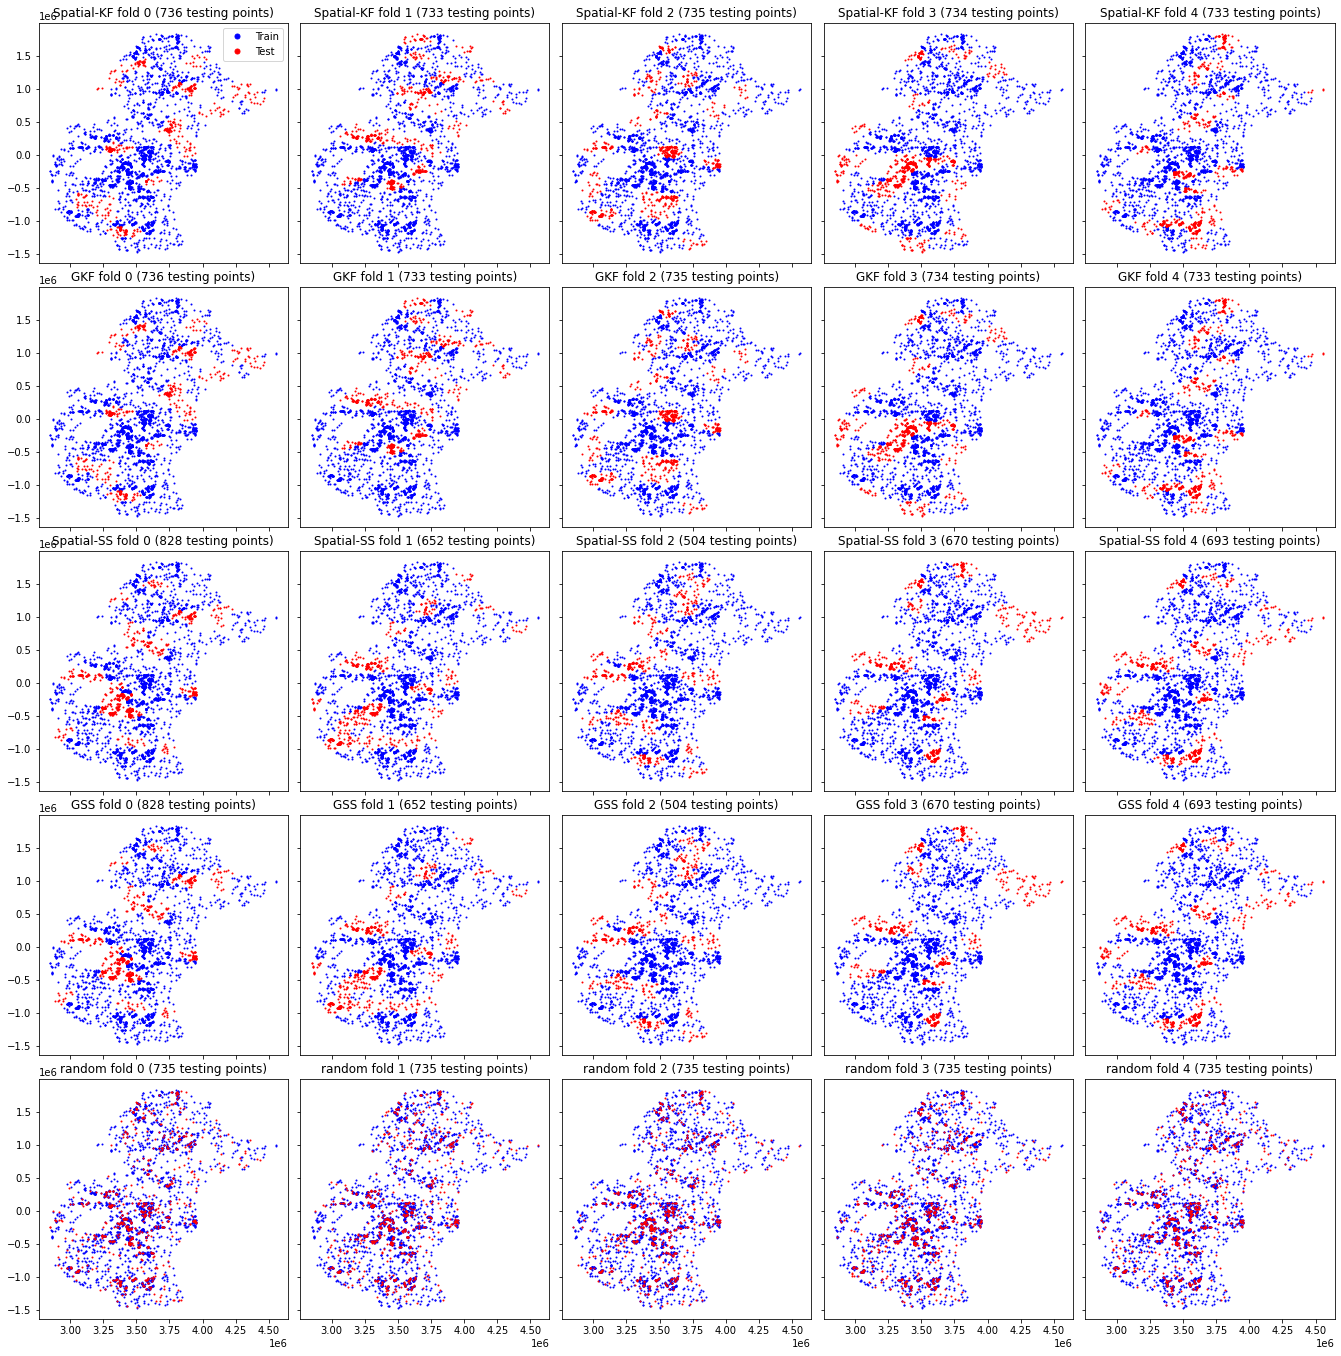

In [15]:
fig, axes = plt.subplots(
    5,
    cv_splits,
    figsize=(20, 20),
    sharex=True,
    sharey=True,
)

for row, title, folds in zip(axes, ['Spatial-KF', 'GKF','Spatial-SS','GSS', 'random'], [kfold,gkf,shuffle, gss, rs]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        X_tr, X_tt = coordinates[train,:], coordinates[test,:]
        
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        ax.plot(
            np.transpose(X_tr)[0],
            np.transpose(X_tr)[1],
            ".b",
            markersize=2,
            label="Train",
        )
        ax.plot(
            np.transpose(X_tt)[0],
            np.transpose(X_tt)[1],
            ".r",
            markersize=2,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()

## Nested CV

In [30]:
# Create the parameter grid
param_grid = {
#     'max_features': ['auto', 'log2', None],
    'n_estimators': [300,400,500],
#     'criterion':['gini', 'entropy']
}
metric = 'balanced_accuracy'
ncpus=2

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score

In [34]:
outer_cv_splits = 2
inner_cv_splits =2
# create outer k-fold splits
outer_cv, spatial_groups = SKCV_simple(coordinates=coordinates,
                    max_distance=max_distance,
                    n_splits=outer_cv_splits,
                    cluster_method=cluster_method,
                    kfold_method='SpatialShuffleSplit',
                    random_state=1,
                    test_size=test_size)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []

# loop through outer splits and test predictions
i=1
for train_index, test_index in outer_cv.split(coordinates, groups=spatial_groups):
    print('working on '+str(i)+'/'+str(outer_cv_splits)+' outer cv split', end='\r')
    model = RandomForestClassifier(random_state=1)

    # index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    coords = coordinates[train_index]

    # inner split on data within outer split
    inner_cv, sg = SKCV_simple(coordinates=coords,
                    max_distance=max_distance,
                    n_splits=inner_cv_splits,
                    cluster_method=cluster_method,
                    kfold_method='SpatialShuffleSplit',
                    random_state=1,
                    test_size=test_size)

    #optimize hyperparameters using innner splits
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=metric,
        n_jobs=ncpus,
        cv=inner_cv.split(coords, groups=sg),
        refit=True,
    )

    clf.fit(X_tr, y_tr)
    #predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_tt, probs)
    auc_ = auc(fpr, tpr)
    roc_auc.append(auc_)
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    # F1 scores
    f1_ = f1_score(y_tt, pred)
    f1.append(f1_)
    i+=1

In [35]:
print("=== Nested Spatial K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))
print("Std F1: "+ str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: "+ str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: "+ str(round(np.std(roc_auc), 2)))

=== Nested Spatial K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.6
Std balanced accuracy: 0.04


Mean F1: 0.53
Std F1: 0.03


Mean roc_auc: 0.642
Std roc_auc: 0.05


## Train-test-split

In [60]:
len(coordinates) * 0.2

734.2

In [71]:
test_sizefeatures, test_features, train_labels, test_labels = spatial_train_test_split(X=model_input[:, model_col_indices],
                                                             y=model_input[:, 0],
                                                             coordinates = coordinates,
                                                             cluster_method='Hierarchical',
                                                             max_distance=max_distance,
                                                             kfold_method = 'SpatialShuffleSplit',                    
                                                             test_size=10,
                                                             n_splits=100,
#                                                              random_state=0, 
                                                                                       verbose=True
                                                             )

print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)

n clusters = 89
train_features shape: (2624, 33)
test_features shape: (676, 33)
